In [2]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time
from astropy.coordinates import HeliocentricMeanEcliptic, HeliocentricTrueEcliptic, SkyCoord

from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

import sunpy.coordinates

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
import scipy.signal 

import time

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
wavelength = 171
corrstatus = "2008onwards"

data = np.genfromtxt("./heliocentricLat_{0}_corrected_{1}.txt".format(wavelength, corrstatus))

badDataMask = (data[:,1] <=0.5) | (data[:,1] > 1.75)
data = data[~badDataMask]

if wavelength == 195:
    mask195oversampling = (data[:,-1] > 2450400) & (data[:,-1] < 2450500)
    data = data[~mask195oversampling]
'''
print(np.shape(data))
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(data[:,0],data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
ax.set_ylim(0,2)
plt.show()
'''
# uniform model
def uniform_ptransform(fitparam):
    """
    transforms a sample drawn from the unit cube [0, 1) to the appropriate uniform prior for the intercept of the flat line
    which I have chosen to be U(0.95, 1.05)
    """
    lineparam = fitparam*(1.05-0.95) + 0.95
    return lineparam

# linear model
def linear_ptransform(fitparams):
    """
    prior on slope is U(-0.025, 0.025)
    prior in intercept is U(0.95,1.05)
    """
    slope = fitparams[0]*(0.025 + 0.025) - 0.025
    intercept = fitparams[1]*(1.05-0.95) + 0.95
    return np.array((slope, intercept))

# linear in cos(lat) model
def linearcos_ptransform(fitparams):
    """
    prior on slope is U(-10,10)
    prior in intercept is U(0.95,1.05)
    """
    slope = fitparams[0]*(10 + 10) - 10
    intercept = fitparams[1]*(1.05-0.95) + 0.95
    return np.array((slope, intercept))

# gaussian log likelihood fn for each model
def uniform_log_likelihood(intercept, norm_flux=data[:,1], norm_fluxerr=data[:,2]):
    """
    following Hogg et al. 2010 chapter 7
    Assuming no covariance between data points and no uncertainty on latitude
    
    Inputs:
    intercept, y, yerr
                
    Returns:
    Log likelihood calculated for these parameters.
    """
    model_flux = intercept
    ll  = -np.sum(0.5*np.log(2*np.pi*norm_fluxerr**2)) - np.sum(((norm_flux - model_flux)**2)/(2*norm_fluxerr**2))
    return ll

def linear_log_likelihood(params, lat=np.abs(data[:,0]), norm_flux=data[:,1], norm_fluxerr=data[:,2]):
    """
    Inputs:
    params = (slope, intercept); flux, fluxerr
    """
    model_flux = params[0]*lat + params[1]
    ll  = -np.sum(0.5*np.log(2*np.pi*norm_fluxerr**2)) - np.sum(((norm_flux - model_flux)**2)/(2*norm_fluxerr**2))
    return ll

def linearcos_log_likelihood(params, coslat = (np.cos(data[:,0]*(np.pi/180.)) - np.cos(data[0,0]*(np.pi/180.))), norm_flux=data[:,1], norm_fluxerr=data[:,2]):
    """
    Inputs:
    params = (slope, intercept); flux, fluxerr
    """
    model_flux = params[0]*coslat + params[1]
    ll  = -np.sum(0.5*np.log(2*np.pi*norm_fluxerr**2)) - np.sum(((norm_flux - model_flux)**2)/(2*norm_fluxerr**2))
    return ll


In [3]:
def compareModels(modelNames, likelihoodFunctionList, priorTransformFunctionList, ndimList):
    results_dicts = []
    
    for i in range(len(modelNames)):
        name = modelNames[i]
        results_dict = {'model_name': name}
        sampler = dynesty.DynamicNestedSampler(loglikelihood=likelihoodFunctionList[i], prior_transform=priorTransformFunctionList[i], ndim=ndimList[i], nlive=1000)
        sampler.run_nested()
        sresults = sampler.results

        #tfig, taxes = dyplot.traceplot(sresults,show_titles=True)
        #cfig, caxes = dyplot.cornerplot(sresults,show_titles=True)
        results_dict['log_z'] = sresults['logz'][-1]
        results_dict['log_z_err'] = sresults['logzerr'][-1]

        samples = sresults.samples  # samples
        weights = sresults.importance_weights()

        # Compute 10%-90% quantiles.
        quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
                     for samps in samples.T]
        
        # Compute weighted mean and covariance.
        mean, cov = dyfunc.mean_and_cov(samples, weights)
       
        results_dict['mean'] = mean
        results_dict['cov'] = cov
        
        # Resample weighted samples.
        samples_equal = sresults.samples_equal()

        results_dict['samples_equal'] = samples_equal

        picklefilename = "./EIT/dynestyrun_{0}_corrected_{1}_{2}.p".format(wavelength, corrstatus, name)
        pickle.dump(results_dict, open(picklefilename, 'wb'))

        results_dicts.append(results_dict)

    return results_dicts

In [4]:
def percentile16(x):
    return np.percentile(x,q=16)
def percentile84(x):
    return np.percentile(x,q=84)
    
def plot_uniform(data, mean, samples_equal):
    mean_model = mean[0]*np.ones_like(data[:,0])
    
    fig, axes = plt.subplots(2,1,figsize=(16,8))
    axes[0].errorbar(data[:,0],data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1,zorder=1)
    axes[0].axhline(1,ls=':',color='k',zorder=2)
    axes[0].plot(data[:,0],mean_model, 'r-', lw=2,zorder=3)
    for i in range(100):
        random_draw = np.random.choice(np.shape(samples_equal)[0])
        axes[0].plot(data[:,0], samples_equal[random_draw][0]*np.ones_like(data[:,0]),color='r',ls='-',lw=0.1,zorder=4)
    axes[0].set_ylim(0.75,1.25)
    
    axes[1].errorbar(data[:,0],data[:,1]-mean_model,data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
    axes[1].axhline(0,ls=':',color='k',zorder=2)
    axes[1].set_ylim(-0.25,0.25)

    binEdges = np.linspace(data[0,0], data[-1,0],100)
    fluxnorm_50 = binned_statistic(data[:,0], data[:,1], statistic='median',bins = binEdges)[0]
    fluxnorm_16 = binned_statistic(data[:,0], data[:,1], statistic=percentile16,bins = binEdges)[0]
    fluxnorm_84 = binned_statistic(data[:,0], data[:,1], statistic=percentile84,bins = binEdges)[0]

    le = fluxnorm_50 - fluxnorm_16
    ue = fluxnorm_84 - fluxnorm_50
    err2d  = np.vstack((le,ue))

    binCenters = (binEdges[0:-1] + binEdges[1:])/2.
    axes[0].errorbar(binCenters, fluxnorm_50, yerr=err2d, ls='None', elinewidth=1, capsize=0, marker='.',ms=15,markeredgecolor='k',c='#3772ff',ecolor='k',alpha=1,zorder=3) 
    mean_model_binned = mean[0]*np.ones_like(binCenters)
    axes[1].errorbar(binCenters, fluxnorm_50-mean_model_binned, yerr=err2d, ls='None', elinewidth=1, capsize=0, marker='.',ms=15,markeredgecolor='k',c='#3772ff',ecolor='k',alpha=1,zorder=3) 

    plt.show()
   
    return

def plot_linear(data, mean, samples_equal):
    mean_model = mean[0]*np.abs(data[:,0]) + mean[1]

    fig, axes = plt.subplots(2,1,figsize=(16,8))
    axes[0].errorbar(np.abs(data[:,0]),data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1,zorder=1)
    axes[0].axhline(1,ls=':',color='k',zorder=2)
    axes[0].plot(np.abs(data[:,0]),mean_model, 'r-', lw=2,zorder=3)
    for i in range(100):
        random_draw = np.random.choice(np.shape(samples_equal)[0])
        trial_model = samples_equal[random_draw][0]*np.abs(data[:,0]) + samples_equal[random_draw][1]
        axes[0].plot(np.abs(data[:,0]), trial_model,color='r',ls='-',lw=0.1,zorder=4)
    axes[0].set_ylim(0.75,1.25)
    
    axes[1].errorbar(np.abs(data[:,0]),data[:,1]-mean_model,data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
    axes[1].axhline(0,ls=':',color='k',zorder=2)
    axes[1].set_ylim(-0.25,0.25)

    binEdges = np.linspace(0, np.abs(data[-1,0]),100)
    fluxnorm_50 = binned_statistic(np.abs(data[:,0]), data[:,1], statistic='median',bins = binEdges)[0]
    fluxnorm_16 = binned_statistic(np.abs(data[:,0]), data[:,1], statistic=percentile16,bins = binEdges)[0]
    fluxnorm_84 = binned_statistic(np.abs(data[:,0]), data[:,1], statistic=percentile84,bins = binEdges)[0]

    le = fluxnorm_50 - fluxnorm_16
    ue = fluxnorm_84 - fluxnorm_50
    err2d  = np.vstack((le,ue))

    binCenters = (binEdges[0:-1] + binEdges[1:])/2.
    axes[0].errorbar(binCenters, fluxnorm_50, yerr=err2d, ls='None', elinewidth=1, capsize=0, marker='.',ms=15,markeredgecolor='k',c='#3772ff',ecolor='k',alpha=1,zorder=3) 
    mean_model_binned = mean[0]*np.abs(binCenters) + mean[1]
    axes[1].errorbar(binCenters, fluxnorm_50-mean_model_binned, yerr=err2d, ls='None', elinewidth=1, capsize=0, marker='.',ms=15,markeredgecolor='k',c='#3772ff',ecolor='k',alpha=1,zorder=3) 

    
    plt.show()

    return

def plot_linearcos(data, mean, samples_equal):
    x = np.cos(data[:,0]*(np.pi/180.))
    x0 = np.cos(data[0,0]*(np.pi/180.))
    
    mean_model = mean[0]*(x-x0) + mean[1]
    
    fig, axes = plt.subplots(2,1,figsize=(16,8))
    axes[0].errorbar(x,data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1,zorder=1)
    axes[0].axhline(1,ls=':',color='k',zorder=2)
    axes[0].plot(x,mean_model, 'r-', lw=2,zorder=3)
    
    for i in range(100):
        random_draw = np.random.choice(np.shape(samples_equal)[0])
        trial_model = samples_equal[random_draw][0]*(x-x0) + samples_equal[random_draw][1]
        axes[0].plot(x, trial_model,color='r',ls='-',lw=0.1,zorder=4)
    axes[0].set_ylim(0.75,1.25)
    
    axes[1].errorbar(x,data[:,1]-mean_model,data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
    axes[1].axhline(0,ls=':',color='k',zorder=2)
    axes[1].set_ylim(-0.25,0.25)

    binEdges = np.linspace(x0, 1,100)
    fluxnorm_50 = binned_statistic(x, data[:,1], statistic='median',bins = binEdges)[0]
    fluxnorm_16 = binned_statistic(x, data[:,1], statistic=percentile16,bins = binEdges)[0]
    fluxnorm_84 = binned_statistic(x, data[:,1], statistic=percentile84,bins = binEdges)[0]

    le = fluxnorm_50 - fluxnorm_16
    ue = fluxnorm_84 - fluxnorm_50
    err2d  = np.vstack((le,ue))

    binCenters = (binEdges[0:-1] + binEdges[1:])/2.
    axes[0].errorbar(binCenters, fluxnorm_50, yerr=err2d, ls='None', elinewidth=1, capsize=0, marker='.',ms=15,markeredgecolor='k',c='#3772ff',ecolor='k',alpha=1,zorder=3) 
    mean_model_binned = mean[0]*(binCenters-x0) + mean[1]
    axes[1].errorbar(binCenters, fluxnorm_50-mean_model_binned, yerr=err2d, ls='None', elinewidth=1, capsize=0, marker='.',ms=15,markeredgecolor='k',c='#3772ff',ecolor='k',alpha=1,zorder=3) 


    plt.show()
    return

In [9]:
def calc_uncertainty(sample_col):
    return 0.5*( (np.percentile(sample_col, 84) - np.percentile(sample_col, 50)) + (np.percentile(sample_col, 50) - np.percentile(sample_col, 16)))

In [5]:
modelNames = ['uniform','linear','linearcos']
results_dicts = compareModels(modelNames=modelNames,likelihoodFunctionList=[uniform_log_likelihood, linear_log_likelihood, linearcos_log_likelihood],priorTransformFunctionList=[uniform_ptransform, linear_ptransform, linearcos_ptransform],ndimList=[1,2,2])

#print(results_dicts)


20582it [00:14, 1469.62it/s, batch: 5 | bound: 1 | nc: 1 | ncall: 58970 | eff(%): 34.892 | loglstar: -35828572.159 <   -inf < -35828571.795 | logz:   -inf +/-  0.266 | stop:  0.958]
28463it [00:14, 1905.61it/s, batch: 4 | bound: 1 | nc: 1 | ncall: 74089 | eff(%): 38.384 | loglstar: -35413219.680 <   -inf < -35413219.293 | logz:   -inf +/-  0.468 | stop:  0.932]
27672it [00:14, 1848.31it/s, batch: 4 | bound: 1 | nc: 1 | ncall: 72771 | eff(%): 37.969 | loglstar: -35338095.275 <   -inf < -35338094.911 | logz:   -inf +/-  0.552 | stop:  0.933]


In [6]:
LC = np.genfromtxt("./EIT/EIT{0}_LC_corrected_{1}.txt".format(wavelength, corrstatus))
metadata = Table.read("./EIT/EIT{0}_metadata.txt".format(wavelength), format='ascii')
cadence = (LC[:,0][1:] - LC[:,0][0:-1])

In [7]:
print(results_dicts[1]['mean'])
print(results_dicts[1]['mean'][0])

[-0.00347106  1.01777576]
-0.0034710551652796153


In [10]:
log_zs = []
for i in range(len(results_dicts)):
    log_zs.append(results_dicts[i]['log_z'])
log_zs = np.array(log_zs)
best_model = np.argmax(log_zs)

uniform_model = results_dicts[0]['mean'][0]*np.ones_like(metadata['HI-LAT-DEG'])
uniform_model_b_unc = calc_uncertainty(results_dicts[0]['samples_equal'])


linear_model = results_dicts[1]['mean'][0]*np.abs(metadata['HI-LAT-DEG']) + results_dicts[1]['mean'][1]
linear_model_m_unc = calc_uncertainty(results_dicts[1]['samples_equal'][:,0])
linear_model_b_unc = calc_uncertainty(results_dicts[1]['samples_equal'][:,1])

x0 = np.cos(data[0,0]*(np.pi/180.))
linearcos_model = results_dicts[2]['mean'][0] * (np.cos(metadata['HI-LAT-DEG']*(np.pi/180.)) - x0) + results_dicts[2]['mean'][1]
linearcos_model_m_unc = calc_uncertainty(results_dicts[2]['samples_equal'][:,0])
linearcos_model_b_unc = calc_uncertainty(results_dicts[2]['samples_equal'][:,1])

if best_model==0:
    print('uniform best')
    LC_corr = LC[:,0]/linear_model
    LC_unc_corr = np.sqrt( (LC[:,2]/uniform_model)**2 + (uniform_model_b_unc**2 * ((LC[:,1])/uniform_model**2)**2) )
elif best_model==1:
    print('linear best')
    LC_corr = LC[:,1]/linear_model
    LC_unc_corr = np.sqrt( (LC[:,2]/linear_model)**2 + (linear_model_m_unc**2 * ((LC[:,1]*np.abs(metadata['HI-LAT-DEG']))/linear_model**2)**2 ) + (linear_model_b_unc**2 * ((LC[:,1])/linear_model**2)**2) )
elif best_model==2:
    print('linearcos best')
    LC_corr = LC[:,1]/linearcos_model
    LC_unc_corr = np.sqrt( (LC[:,2]/linearcos_model)**2 + (linearcos_model_m_unc**2 * ((LC[:,1]*np.cos(metadata['HI-LAT-DEG']*(np.pi/180.)))/linearcos_model**2)**2 ) + (linearcos_model_b_unc**2 * ((LC[:,1])/linearcos_model**2)**2) )

toSave = np.vstack((LC[:,0], LC_corr, LC_unc_corr, LC[:,3], LC[:,4])).T
header = 'average_observation_time[JD] flux[DN/s] flux_unc[DN/s] last_data_point_before_bakeout first_data_point_after_bakeout'
np.savetxt("./EIT/EIT{0}_LC_corrected_{1}_heliocentriccorr.txt".format(wavelength, corrstatus), toSave, fmt='%f %f %f %d %d', delimiter=' ', header=header)

linearcos best


In [13]:
for w in np.array((171,195,284,304)):
    print(w)
    results_uniform = pickle.load(open('./EIT/dynestyrun_{0}_corrected_2008onwards_uniform.p'.format(w), 'rb'))
    results_linear = pickle.load(open('./EIT/dynestyrun_{0}_corrected_2008onwards_linear.p'.format(w), 'rb'))
    results_linearcos = pickle.load(open('./EIT/dynestyrun_{0}_corrected_2008onwards_linearcos.p'.format(w),'rb'))

    print("left col is {0} +/- {1}".format(results_linearcos['log_z'] - results_uniform['log_z'], np.sqrt(results_linearcos['log_z_err']**2 + results_uniform['log_z_err']**2)))
    print("right col is {0} +/- {1}".format(results_linearcos['log_z'] - results_linear['log_z'], np.sqrt(results_linearcos['log_z_err']**2 + results_linear['log_z_err']**2)))
    print("")

    results_uniform = pickle.load(open('./EIT/dynestyrun_{0}_corrected_all_uniform.p'.format(w), 'rb'))
    results_linear = pickle.load(open('./EIT/dynestyrun_{0}_corrected_all_linear.p'.format(w), 'rb'))
    results_linearcos = pickle.load(open('./EIT/dynestyrun_{0}_corrected_all_linearcos.p'.format(w),'rb'))

    print("left col is {0} +/- {1}".format(results_linearcos['log_z'] - results_uniform['log_z'], np.sqrt(results_linearcos['log_z_err']**2 + results_uniform['log_z_err']**2)))
    print("right col is {0} +/- {1}".format(results_linearcos['log_z'] - results_linear['log_z'], np.sqrt(results_linearcos['log_z_err']**2 + results_linear['log_z_err']**2)))
    print("")

171
left col is 497017.2701680213 +/- 0.5571925111421066
right col is 74251.16263985634 +/- 0.7841002567709511

left col is 19.517544375241414 +/- 0.07047431398748827
right col is 2.5469433773942 +/- 0.08464459361178527

195
left col is 645724.233811006 +/- 0.35417785466366486
right col is 70063.53619366884 +/- 0.3884456876400484

left col is 74.31840297996314 +/- 0.07134782971464312
right col is -3.761199789445527 +/- 0.08484247819243736

284
left col is 11096.172964550788 +/- 0.0876869333408963
right col is 1374.228387934214 +/- 0.10416088843167866

left col is 221.09710734458713 +/- 0.06803895109235225
right col is 53.46572924102202 +/- 0.08202255844001129

304
left col is 119162.36760570388 +/- 0.10828999615089187
right col is -2408.5625616014004 +/- 0.12005388240159069

left col is 131.338865976948 +/- 0.075614300998249
right col is 8.28264429849878 +/- 0.09016512271210068



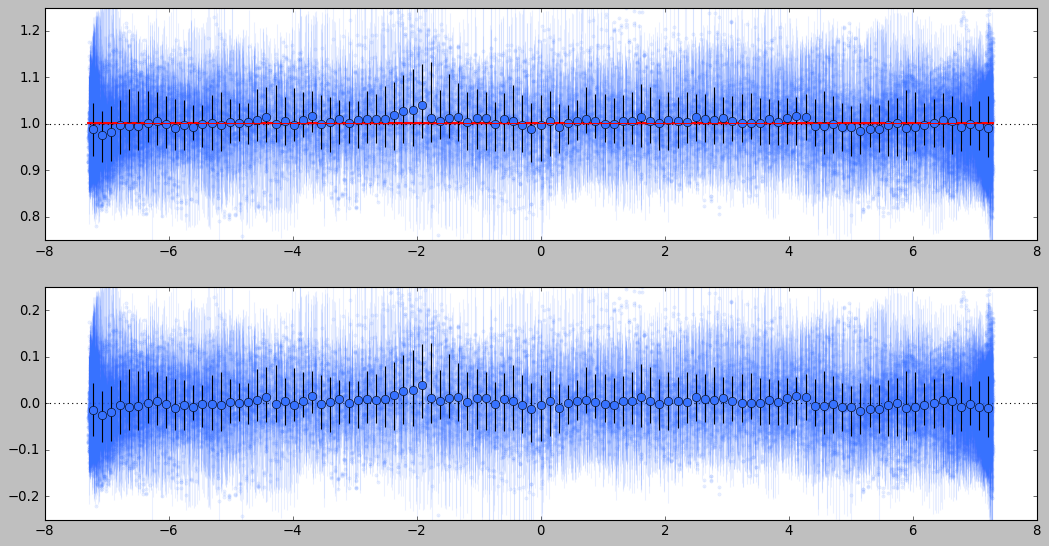

8.42121111244154e-06
1.0017406768905395
8.483515975710176e-06



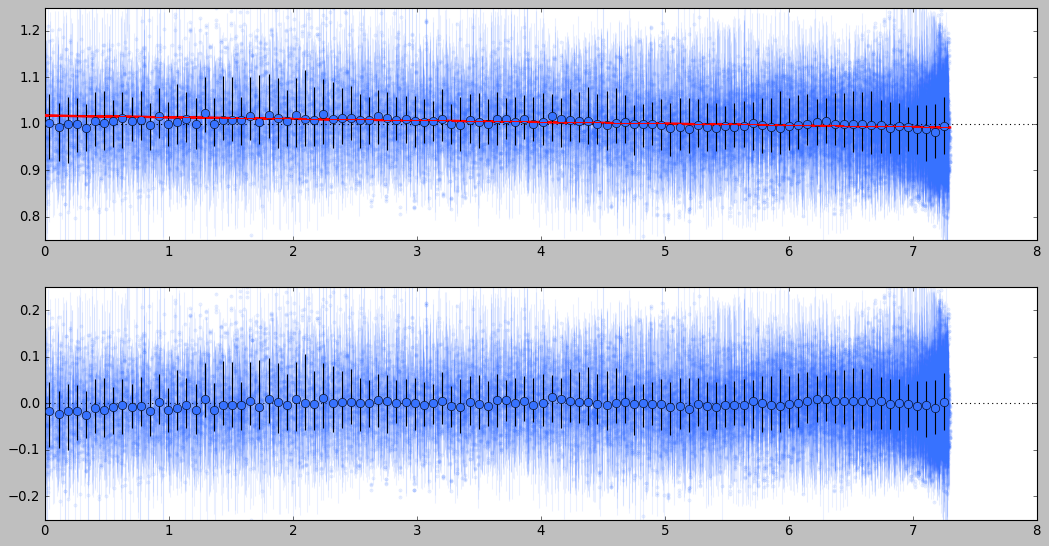

3.81969479117247e-06
-0.0034709865130898507
3.771340492737807e-06

1.896940644674494e-05
1.0177753050116765
1.977097957550633e-05



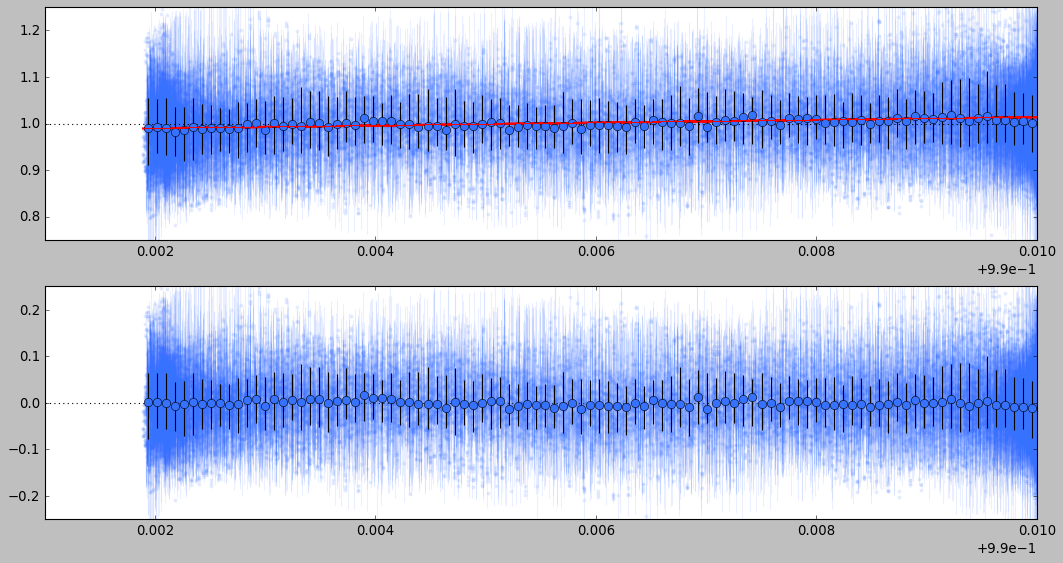

0.002998261205194197
2.998589444917423
0.0029464226865556498

1.4801196287828056e-05
0.9894427469732681
1.456688932222061e-05



In [72]:
for i in range(len(results_dicts)):
    name = results_dicts[i]['model_name']

    if name=='uniform':
        plot_uniform(data, results_dicts[i]['mean'], results_dicts[i]['samples_equal'])
    elif name=='linear':
        plot_linear(data, results_dicts[i]['mean'], results_dicts[i]['samples_equal'])
    elif name=='linearcos':
        plot_linearcos(data, results_dicts[i]['mean'], results_dicts[i]['samples_equal'])
        
    for j in range(np.shape(results_dicts[i]['samples_equal'])[1]):
        p16 = np.percentile(results_dicts[i]['samples_equal'][:,j], 16)
        p50 = np.percentile(results_dicts[i]['samples_equal'][:,j], 50)
        p84 = np.percentile(results_dicts[i]['samples_equal'][:,j], 84)
        print(p50-p16)
        print(p50)
        print(p84-p50)
        print("")
        '''
        fig, ax = plt.subplots(1,1,figsize=(4,4))
        ax.hist(results_dicts[i]['samples_equal'][:,j],bins=200)
        ax.axvline(p16,color='k',linestyle=':')
        ax.axvline(p50,color='k',linestyle=':')
        ax.axvline(p84,color='k',linestyle=':')
        plt.show()
        '''

In [10]:
print(log_zs[1] - log_zs[0])
print(log_zs[2] - log_zs[0])
print(log_zs[2] - log_zs[1])

415344.18792277575
490469.09893754125
75124.9110147655


In [11]:
print(means[2])

[2.99873723 0.98944219]


# test dividing this trend out of the time series and seeing what happens to the power spectrum

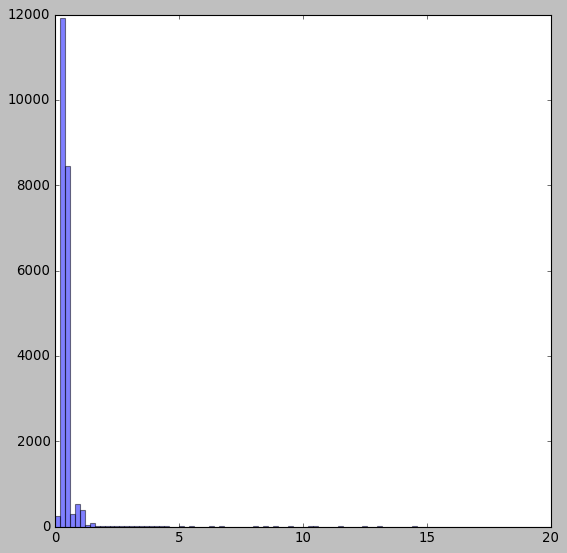

In [27]:
# pre-dividing out
LC = np.genfromtxt("./EIT/EIT{0}_LC_corrected_{1}.txt".format(wavelength, corr))
metadata = Table.read("./EIT/EIT{0}_metadata.txt".format(wavelength), format='ascii')
cadence = (LC[:,0][1:] - LC[:,0][0:-1])
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.hist(cadence, color='b', alpha=0.5, bins=100, range=(0,20))
plt.show()

excludemask = (LC[:,1] > 0.5e8)
metadata = metadata[excludemask]
LC = LC[excludemask]


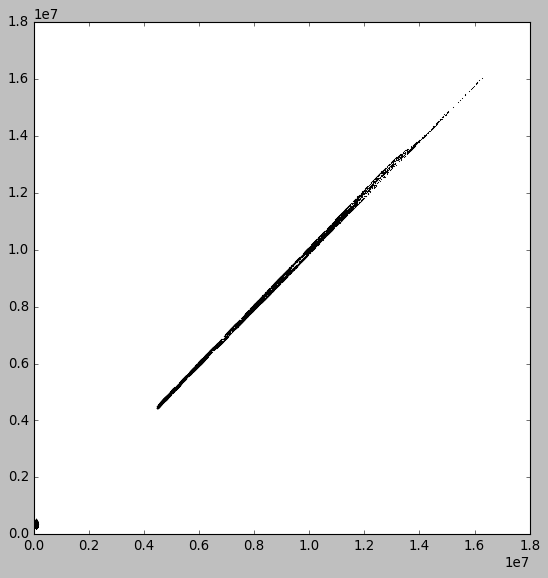

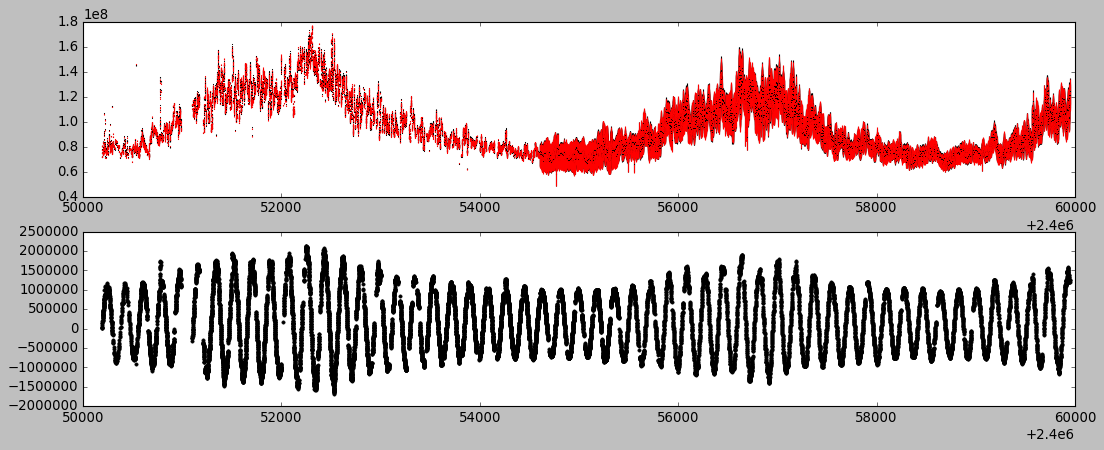

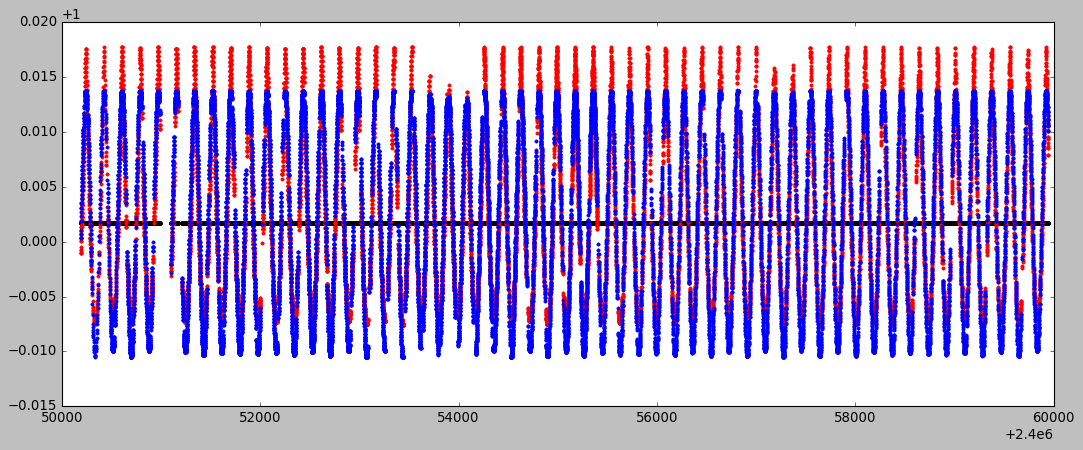

In [14]:
# form of best-fitting model is: flux = m*cos(heliocentric_lat) + b 
# therefore fluxcorr = flux / m*cos(heliocentric_lat) + b
uniform_model = means[0]*np.ones_like(metadata['HI-LAT-DEG'])
uniform_model_b_unc = calc_uncertainty(samplearrs[0])
#LC_corr = LC[:,0]/linear_model

linear_model = means[1][0]*np.abs(metadata['HI-LAT-DEG']) + means[1][1]
linear_model_m_unc = calc_uncertainty(samplearrs[1][:,0])
linear_model_b_unc = calc_uncertainty(samplearrs[1][:,1])
#LC_corr = LC[:,1]/linear_model
#LC_unc_corr = np.sqrt( (LC[:,2]/linear_model)**2 + (linear_model_m_unc**2 * ((LC[:,1]*np.abs(metadata['HI-LAT-DEG']))/linear_model**2)**2 ) + (linear_model_b_unc**2 * ((LC[:,1])/linear_model**2)**2) )

x0 = np.cos(data[0,0]*(np.pi/180.))
linearcos_model = means[2][0] * (np.cos(metadata['HI-LAT-DEG']*(np.pi/180.)) - x0) + means[2][1]
linearcos_model_m_unc = calc_uncertainty(samplearrs[2][:,0])
linearcos_model_b_unc = calc_uncertainty(samplearrs[2][:,1])
LC_corr = LC[:,1]/linearcos_model
LC_unc_corr = np.sqrt( (LC[:,2]/linearcos_model)**2 + (linearcos_model_m_unc**2 * ((LC[:,1]*np.cos(metadata['HI-LAT-DEG']*(np.pi/180.)))/linearcos_model**2)**2 ) + (linearcos_model_b_unc**2 * ((LC[:,1])/linearcos_model**2)**2) )


fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(LC[:,2], LC_unc_corr, 'k.',ms=1)
plt.show()


fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].errorbar(LC[:,0], LC[:,1],LC[:,2], color='k', marker='.',ms=1,ls='None',elinewidth=1,capsize=0)
axes[0].errorbar(LC[:,0], LC_corr, LC_unc_corr, color='r', marker='.',ms=1,ls='None',elinewidth=1,capsize=0)
axes[1].plot(LC[:,0], LC[:,1] - LC_corr, 'k.')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(LC[:,0], uniform_model, 'k.')
ax.plot(LC[:,0], linear_model, 'r.')
ax.plot(LC[:,0], linearcos_model, 'b.')
plt.show()

In [48]:
norm = np.median(LC[:,1])
freq, pow = LombScargle(LC[:,0],LC[:,1]/norm,LC[:,2]/norm).autopower(minimum_frequency=(1./np.ptp(LC[:,0])), maximum_frequency=(1./2))
freq_corr, pow_corr = LombScargle(LC[:,0],LC_corr/norm,LC_unc_corr/norm).autopower(minimum_frequency=(1./np.ptp(LC[:,0])), maximum_frequency=(1./2))
freq_model, pow_model = LombScargle(LC[:,0], linearcos_model).autopower(minimum_frequency=(1./np.ptp(LC[:,0])), maximum_frequency=(1./2))
testf, testp = LombScargle(LC[:,0], np.ones_like(LC[:,0]), 0.00001*np.ones_like(LC[:,0])).autopower(minimum_frequency=(1./np.ptp(LC[:,0])), maximum_frequency=(1./2))

In [49]:
def medianBinEIT(tDaily, tEIT, fEIT, uEIT):
    '''
    median-bin the flux from one EIT band into daily values
    '''
    binned_f, bin_edges, binnumber = binned_statistic(x=tEIT, values=fEIT, statistic='median', bins=tDaily)
    binned_u, bin_edges, binnumber = binned_statistic(x=tEIT, values=uEIT, statistic='mean', bins=tDaily)
    binned_u = np.sqrt((np.pi/2)*binned_u)
    return binned_f, binned_u

In [62]:
print(LC[:,0])
print(LC[-1,0])
print(len(cadence))
print(len(LC[:,0]))

[2450190.179292 2450190.243848 2450190.445543 ... 2459944.040571
 2459944.541603 2459945.041858]
2459945.041858
22102
22079


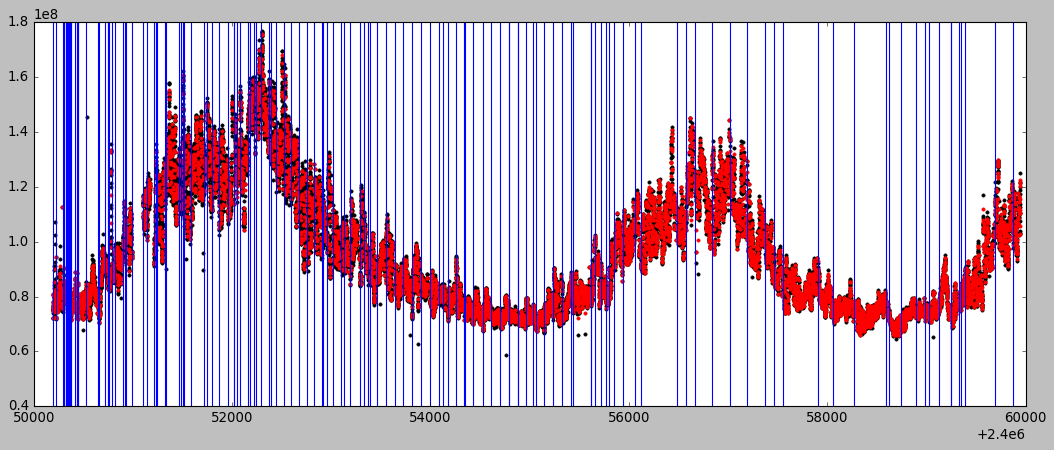

In [64]:
tDaily = np.arange(np.floor(LC[0,0]),np.ceil(LC[-1,0])+1,1)
LC_daily_binned, LC_unc_daily_binned = medianBinEIT(tDaily, LC[:,0], LC[:,1], LC[:,2])
noNans = ~np.isnan(LC_daily_binned) & ~np.isnan(LC_unc_daily_binned)
tDailyMid = (tDaily[0:-1]+tDaily[1:])/2

LC_corr_daily_binned, LC_corr_unc_daily_binned = medianBinEIT(tDaily, LC[:,0], LC_corr, LC_unc_corr)
noNans_corr = ~np.isnan(LC_corr_daily_binned) & ~np.isnan(LC_corr_unc_daily_binned)


fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(LC[:,0], LC[:,1],'k.')
ax.plot(tDailyMid, LC_daily_binned, 'r.')
for i in range(len(cadence)):
    if cadence[i] > 2:
        ax.axvline(LC[:,0][i-1])
plt.show()


freq_binned, pow_binned = LombScargle(tDailyMid[noNans],LC_daily_binned[noNans]/norm,LC_unc_daily_binned[noNans]/norm).autopower(minimum_frequency=(1./np.ptp(tDailyMid)), maximum_frequency=(1./2.))
freq_corr_binned, pow_corr_binned = LombScargle(tDailyMid[noNans_corr],LC_corr_daily_binned[noNans_corr]/norm,LC_corr_unc_daily_binned[noNans_corr]/norm).autopower(minimum_frequency=(1./np.ptp(tDailyMid)), maximum_frequency=(1./2.))


testf_binned, testp_binned =  LombScargle(tDailyMid,np.ones_like(tDailyMid), 0.0001*np.ones_like(tDailyMid)).autopower(minimum_frequency=(1./np.ptp(tDailyMid)), maximum_frequency=(1./2.))

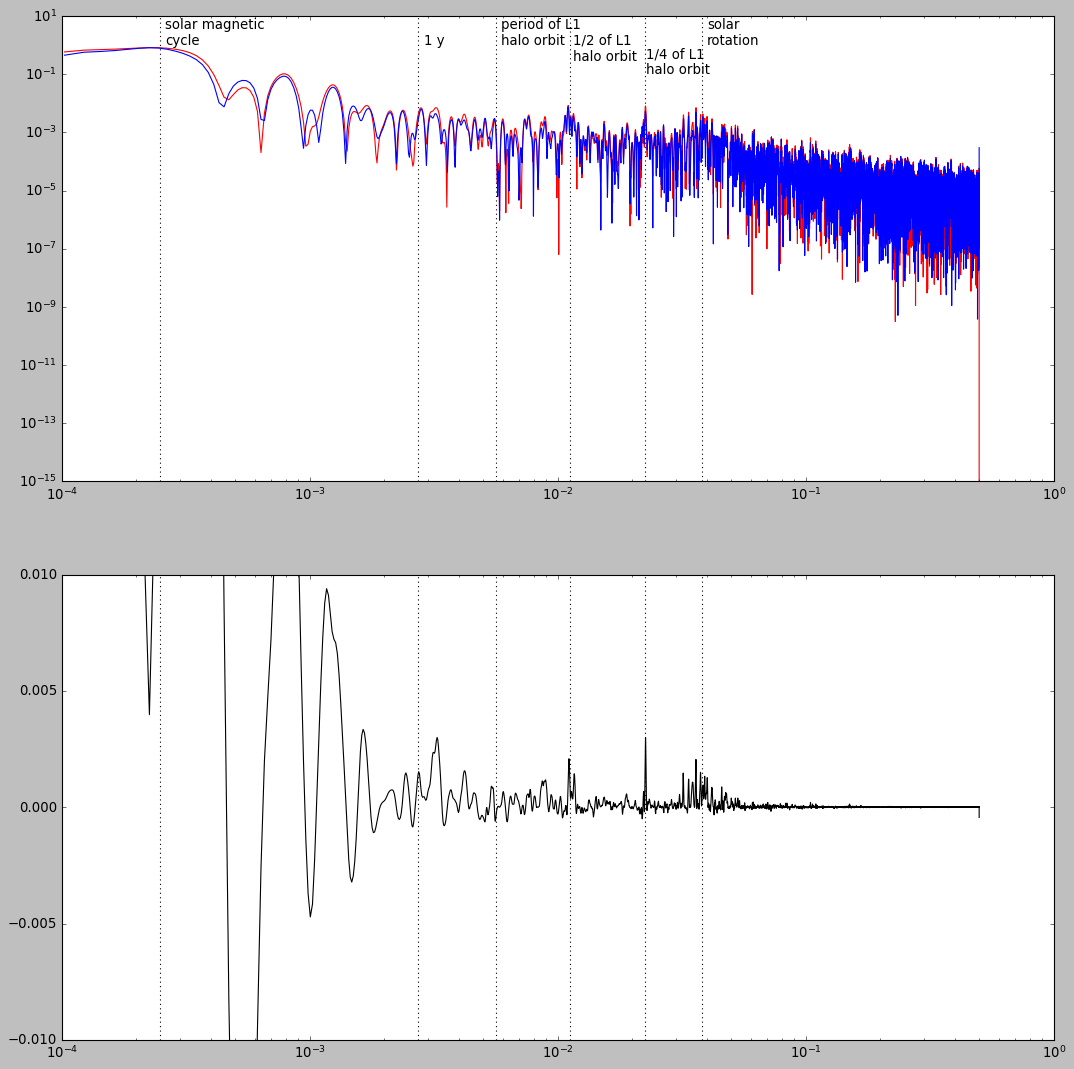

In [67]:
fig, axes = plt.subplots(2,1,figsize=(16,16))
#axes[0].plot(freq,pow,'k-',zorder=2)
#axes[0].plot(freq_corr,pow_corr,'r-',zorder=3)
#axes[0].plot(freq_model,pow_model*1.e-6,'b-',zorder=1)
#axes[0].plot(testf,testp,'k-')
#axes[0].plot(testf_binned, testp_binned, 'k-')
axes[0].plot(freq_binned, pow_binned, 'r-')
axes[0].plot(freq_corr_binned, pow_corr_binned, 'b-')

axes[0].set_yscale("log")
axes[0].set_ylim(1.e-15, 1.e1)

for ax in axes:
    ax.set_xscale("log")
    ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
    ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
    ax.axvline(2./178., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
    ax.axvline(4./178., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
    ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
    ax.axvline(1./(11*365.),color='k',ls=':',zorder=1) #magnetic cycle
    
axes[0].text(1.05/26.24, 1.e0, 'solar'+'\n'+'rotation',fontsize=12)
axes[0].text(1.05/178., 1.e0, 'period of L1'+'\n'+'halo orbit',fontsize=12)
axes[0].text(1.05/365., 1.e0, '1 y',fontsize=12)
axes[0].text(2.05/178., 3.e-1, '1/2 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
axes[0].text(4.05/178., 1.e-1, '1/4 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
axes[0].text(1.05/(365*11), 1.e0, 'solar magnetic'+'\n'+'cycle',fontsize=12)

axes[1].plot(freq, pow_binned - pow_corr_binned, 'k-')
axes[1].set_ylim(-0.01, 0.01)
plt.show()

In [17]:
print(metadata.colnames)

['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS', 'HI-LAT-DEG', 'HI-LON-DEG']


# old code - fit models one at a time

20389it [00:13, 1483.32it/s, batch: 5 | bound: 1 | nc: 1 | ncall: 57671 | eff(%): 35.348 | loglstar: -35828572.101 <   -inf < -35828571.749 | logz:   -inf +/-  0.434 | stop:  0.963]


Summary
niter: 20389
ncall: 57577
eff(%): 35.348
logz: -35828577.897 +/-  0.175
[1.00174069] [[7.11754884e-11]]
(20389, 1)
()


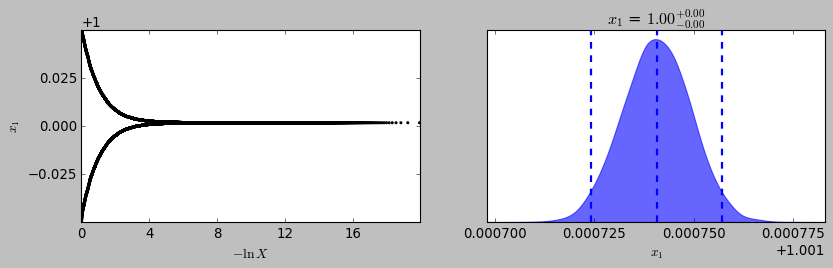

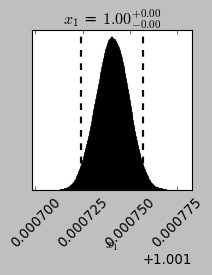

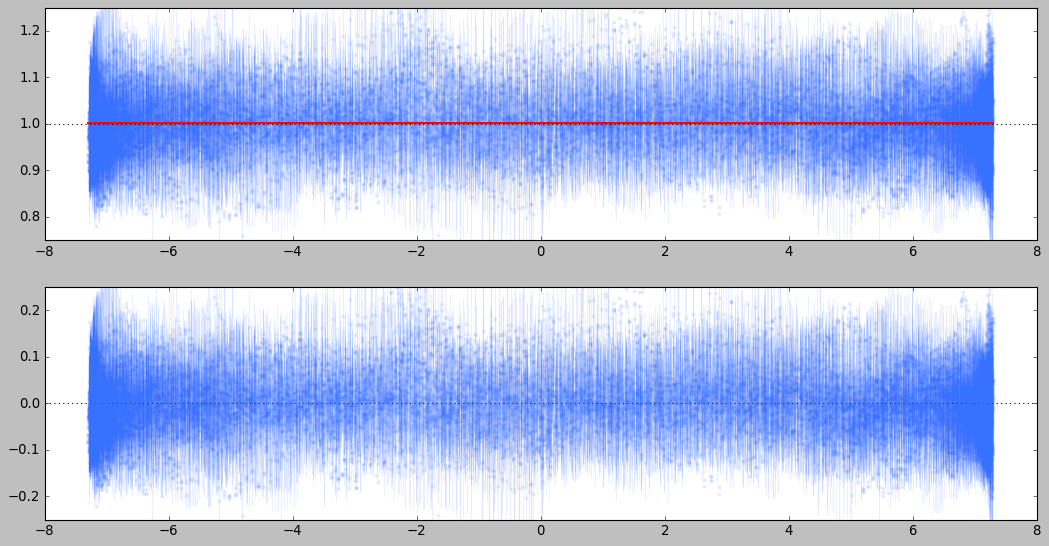

In [6]:
# Fit the uniform model.
uniform_ndim = 1

# "Static" nested sampling.
sampler = dynesty.DynamicNestedSampler(loglikelihood=uniform_log_likelihood, prior_transform=uniform_ptransform, ndim=uniform_ndim, nlive=1000)
sampler.run_nested()
sresults = sampler.results

sresults.summary()

#rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults,show_titles=True)
cfig, caxes = dyplot.cornerplot(sresults,show_titles=True)

# Extract sampling results.
samples = sresults.samples  # samples
weights = sresults.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean,cov)

# Resample weighted samples.
samples_equal = sresults.samples_equal()
print(np.shape(samples_equal))

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(sresults)
print(np.shape(results_sim))

#plot data, model, residuals
mean_model = mean[0]*np.ones_like(data[:,0])

fig, axes = plt.subplots(2,1,figsize=(16,8))
axes[0].errorbar(data[:,0],data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1,zorder=1)
axes[0].axhline(1,ls=':',color='k',zorder=2)
axes[0].plot(data[:,0],mean_model, 'r-', lw=2,zorder=3)
for i in range(100):
    random_draw = np.random.choice(np.shape(samples_equal)[0])
    axes[0].plot(data[:,0], samples_equal[random_draw][0]*np.ones_like(data[:,0]),color='r',ls='-',lw=0.1,zorder=4)
axes[0].set_ylim(0.75,1.25)

axes[1].errorbar(data[:,0],data[:,1]-mean_model,data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
axes[1].axhline(0,ls=':',color='k',zorder=2)
axes[1].set_ylim(-0.25,0.25)
plt.show()

28313it [00:14, 1909.99it/s, batch: 4 | bound: 1 | nc: 1 | ncall: 73135 | eff(%): 38.701 | loglstar: -35413219.706 <   -inf < -35413219.333 | logz:   -inf +/-  0.620 | stop:  0.941]


Summary
niter: 28313
ncall: 72979
eff(%): 38.701
logz: -35413233.571 +/-  0.301


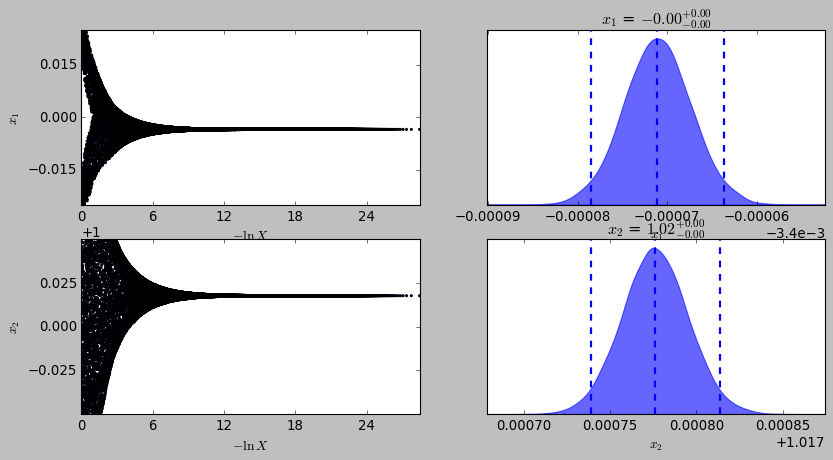

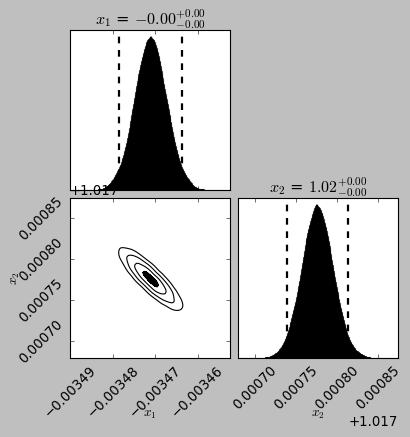

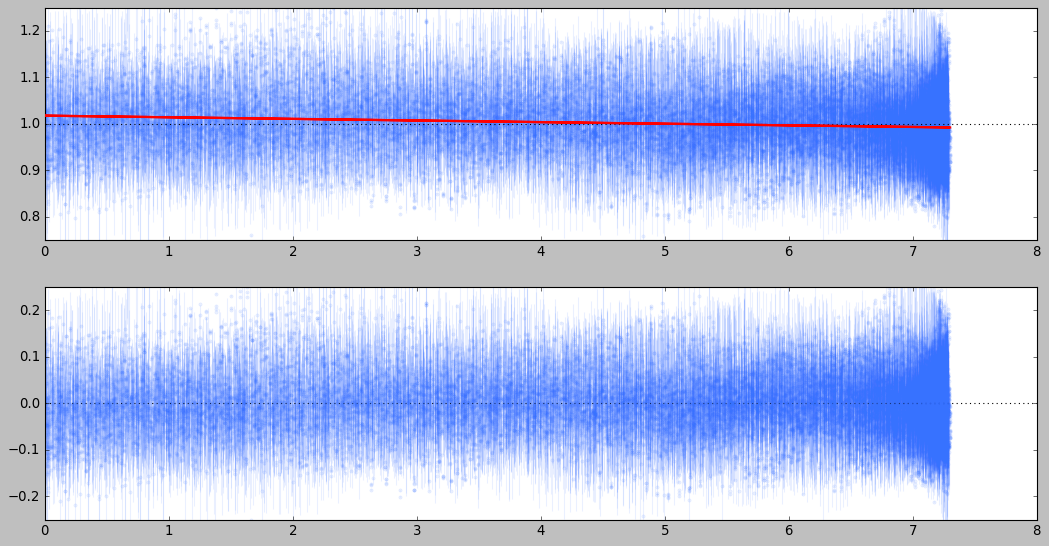

In [7]:
# Fit the linear model.
linear_ndim = 2

# "Static" nested sampling.
sampler = dynesty.DynamicNestedSampler(loglikelihood=linear_log_likelihood, prior_transform=linear_ptransform, ndim=linear_ndim, nlive=1000)
sampler.run_nested()
sresults = sampler.results

sresults.summary()

#rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults,show_titles=True)
cfig, caxes = dyplot.cornerplot(sresults,show_titles=True)

# Extract sampling results.
samples = sresults.samples  # samples
weights = sresults.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = sresults.samples_equal()

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(sresults)

#plot data, model, residuals
mean_model = mean[0]*np.abs(data[:,0]) + mean[1]

fig, axes = plt.subplots(2,1,figsize=(16,8))
axes[0].errorbar(np.abs(data[:,0]),data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1,zorder=1)
axes[0].axhline(1,ls=':',color='k',zorder=2)
axes[0].plot(np.abs(data[:,0]),mean_model, 'r-', lw=2,zorder=3)
for i in range(100):
    random_draw = np.random.choice(np.shape(samples_equal)[0])
    trial_model = samples_equal[random_draw][0]*np.abs(data[:,0]) + samples_equal[random_draw][1]
    axes[0].plot(np.abs(data[:,0]), trial_model,color='r',ls='-',lw=0.1,zorder=4)
axes[0].set_ylim(0.75,1.25)

axes[1].errorbar(np.abs(data[:,0]),data[:,1]-mean_model,data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
axes[1].axhline(0,ls=':',color='k',zorder=2)
axes[1].set_ylim(-0.25,0.25)
plt.show()

27682it [00:14, 1912.18it/s, batch: 4 | bound: 1 | nc: 1 | ncall: 72094 | eff(%): 38.336 | loglstar: -35338095.213 <   -inf < -35338094.826 | logz:   -inf +/-  0.323 | stop:  0.934]


Summary
niter: 27682
ncall: 71912
eff(%): 38.336
logz: -35338108.472 +/-  0.523


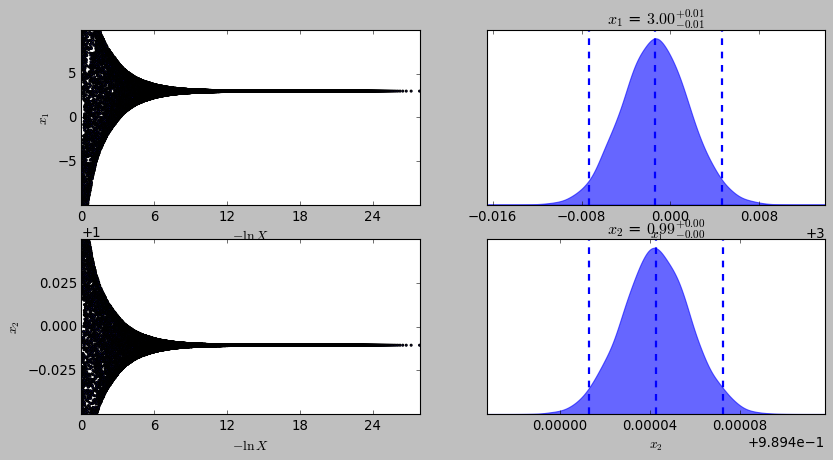

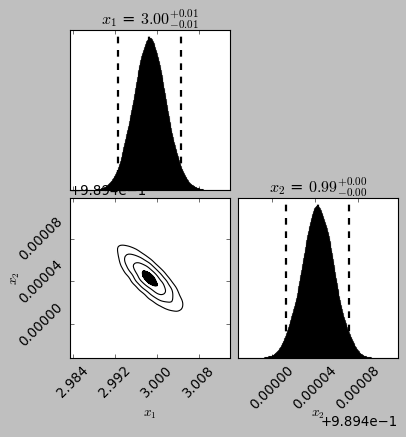

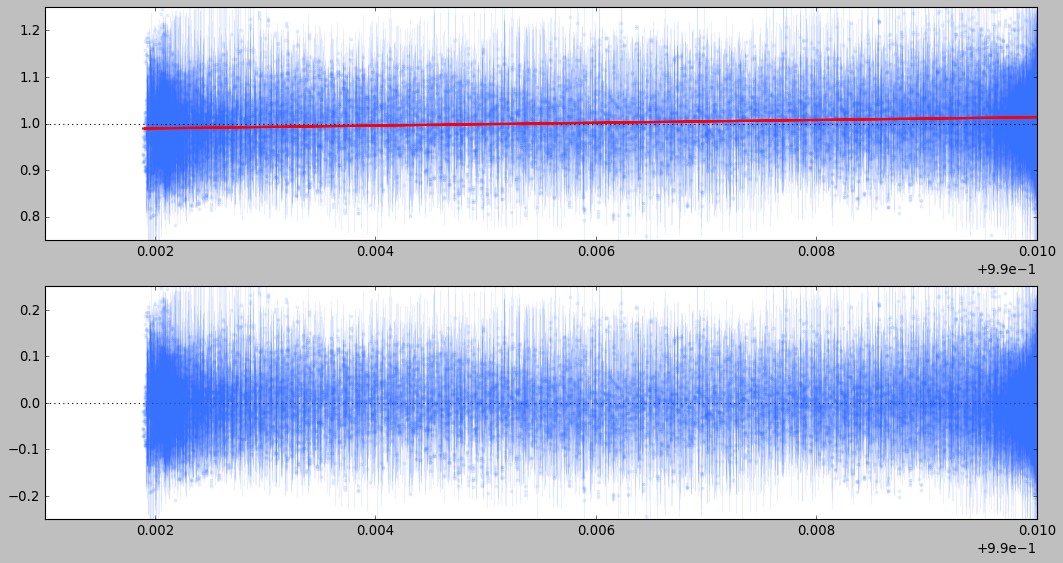

In [8]:
# Fit the linear in cos(lat) model.
linearcos_ndim = 2

# "Static" nested sampling.
sampler = dynesty.DynamicNestedSampler(loglikelihood=linearcos_log_likelihood, prior_transform=linearcos_ptransform, ndim=linearcos_ndim, nlive=1000)
sampler.run_nested()
sresults = sampler.results

sresults.summary()

#rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults,show_titles=True)
cfig, caxes = dyplot.cornerplot(sresults,show_titles=True)

# Extract sampling results.
samples = sresults.samples  # samples
weights = sresults.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = sresults.samples_equal()

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(sresults)

#plot data, model, residuals
x = np.cos(data[:,0]*(np.pi/180.))
x0 = np.cos(data[0,0]*(np.pi/180.))

mean_model = mean[0]*(x-x0) + mean[1]

fig, axes = plt.subplots(2,1,figsize=(16,8))
axes[0].errorbar(x,data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1,zorder=1)
axes[0].axhline(1,ls=':',color='k',zorder=2)
axes[0].plot(x,mean_model, 'r-', lw=2,zorder=3)

for i in range(100):
    random_draw = np.random.choice(np.shape(samples_equal)[0])
    trial_model = samples_equal[random_draw][0]*(x-x0) + samples_equal[random_draw][1]
    axes[0].plot(x, trial_model,color='r',ls='-',lw=0.1,zorder=4)
axes[0].set_ylim(0.75,1.25)

axes[1].errorbar(x,data[:,1]-mean_model,data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
axes[1].axhline(0,ls=':',color='k',zorder=2)
axes[1].set_ylim(-0.25,0.25)

plt.show()